In [229]:
import os
import math
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize, signal

from lmfit import models

# ignore used to produce images for blog
image_dir = "images"
def plot_to_blog(fig, figure_name):
    filename = os.path.expanduser(f'{image_dir}/{figure_name}')
    fig.savefig(filename)
    return filename

def g(A, μ, σ, x = np.linspace(0, 45, 45*10)):
    return A / (σ * math.sqrt(2 * math.pi)) * np.exp(-(x-μ)**2 / (2*σ**2))

def generate_model(spec):
    composite_model = None
    params = None
    x = spec['x']
    y = spec['y']
    x_min = np.min(x)
    x_max = np.max(x)
    x_range = x_max - x_min
    y_max = np.max(y)
    for i, basis_func in enumerate(spec['model']):
        prefix = f'm{i}_'
        model = getattr(models, basis_func['type'])(prefix=prefix)
        if basis_func['type'] in ['GaussianModel', 'LorentzianModel', 'VoigtModel']:
            model.set_param_hint('sigma', min=1e-6, max=x_range)
            model.set_param_hint('center', min=x_min, max=x_max)
            model.set_param_hint('height', min=1e-6, max=1.1*y_max)
            model.set_param_hint('amplitude', min=1e-6)
            #
            default_params = {
                prefix+'center': x_min + x_range * random.random(),
                prefix+'height': y_max * random.random(),
                prefix+'sigma': x_range * random.random()
            }
        else:
            raise NotImplemented(f'model {basis_func["type"]} not implemented yet')
        if 'help' in basis_func:  # allow override of settings in parameter
            for param, options in basis_func['help'].items():
                model.set_param_hint(param, **options)
        model_params = model.make_params(**default_params, **basis_func.get('params', {}))
        if params is None:
            params = model_params
        else:
            params.update(model_params)
        if composite_model is None:
            composite_model = model
        else:
            composite_model = composite_model + model
    return composite_model, params

def update_spec_from_peaks(spec, model_indicies, peak_widths=(10, 25), **kwargs):
    x = spec['x']
    y = spec['y']
    x_range = np.max(x) - np.min(x)
    peak_indicies = signal.find_peaks_cwt(y, peak_widths)
    np.random.shuffle(peak_indicies)
    for peak_indicie, model_indicie in zip(peak_indicies.tolist(), model_indicies):
        model = spec['model'][model_indicie]
        if model['type'] in ['GaussianModel', 'LorentzianModel', 'VoigtModel']:
            params = {
                'height': y[peak_indicie],
                'sigma': x_range / len(x) * np.min(peak_widths),
                'center': x[peak_indicie]
            }
            if 'params' in model:
                model.update(params)
            else:
                model['params'] = params
        else:
            raise NotImplemented(f'model {basis_func["type"]} not implemented yet')
    return peak_indicies

def print_best_values(spec, output):
    model_params = {
        'GaussianModel':   ['amplitude', 'sigma'],
        'LorentzianModel': ['amplitude', 'sigma'],
        'VoigtModel':      ['amplitude', 'sigma', 'gamma'],
        'LinearModel': []
    }
    best_values = output.best_values
    print('center   model            amplitude     sigma     gamma')
    for i, model in enumerate(spec['model']):
        prefix = f'm{i}_'
        values = ', '.join(f'{best_values[prefix+param]:8.3f}' for param in model_params[model["type"]])
        print(f'[{best_values[prefix+"center"]:3.3f}] {model["type"]:16}: {values}')

def crystallinity(output,amorph_index):
    a = 0
    b = 0
    for i, model in enumerate(spec['model']):
        if i in amorph_index:
            b = b+(output.best_values[f'm{i}_amplitude'])
        else:
            a = a+(output.best_values[f'm{i}_amplitude'])
    
    return a/(a+b)

def crystallinity2(output,amorph_index):
    a = 0
    b = 0
    for i, model in enumerate(spec['model']):
        if i in amorph_index:
            b = b+(output.values[f'm{i}_height'])
        else:
            a = a+(output.values[f'm{i}_height'])
    
    return a/(a+b)

     2Theta   I
0     15.02  28
1     15.04  42
2     15.06  52
3     15.08  30
4     15.10  40
..      ...  ..
619   27.40  16
620   27.42   0
621   27.44   0
622   27.46   6
623   27.48   8

[624 rows x 2 columns]


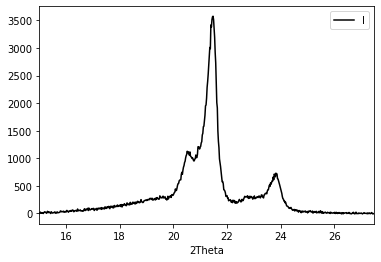

In [213]:
#data import
df = pd.read_csv('PEAD.csv', delim_whitespace=True, skiprows=32,
                 names=['2Theta','I'])
df = df[df['2Theta']<27.5]
df['I']=df['I']-df['I'].min()
alpha = (df['I'].iat[0]-df['I'].iat[-1])/(df['2Theta'].iat[0]-df['2Theta'].iat[-1])
beta = df['I'].iat[-1]-alpha*df['2Theta'].iat[-1]
correction = alpha*df['2Theta']+beta
df['I']=df['I']-correction
df.plot(kind = 'line', x='2Theta',y='I',color='black')

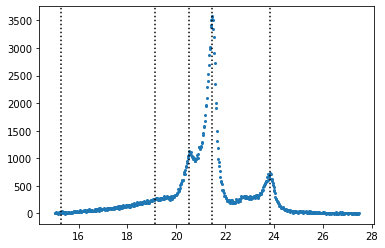

In [216]:
#usar este código para os chutes iniciais automáticos em spec

Manual = False

if not Manual:
    spec = {
        'x': df['2Theta'].values,
        'y': df['I'].values,
        'model': [
            {'type': 'GaussianModel'},
            {'type': 'GaussianModel'},
            {'type': 'GaussianModel'},
            {'type': 'GaussianModel'},
            ]
    }

    peaks_found = update_spec_from_peaks(spec, [0, 1, 2], peak_widths=(10,))
    fig, ax = plt.subplots()
    ax.scatter(spec['x'], spec['y'], s=4)
    for i in peaks_found:
        ax.axvline(x=spec['x'][i], c='black', linestyle='dotted')

    plot_to_blog(fig, 'xrd-fitting-xrd-peaks.png')

In [217]:
#usar este código para os chutes iniciais manuais em spec

#Manual = True

if Manual:
    spec = {
        'x': df['2Theta'].values,
        'y': df['I'].values,
        'model': [
            {
                'type': 'GaussianModel',
                'params': {'center': 16.02, 'height': 743, 'sigma': 0.1},
                'help': {'center': {'min': 15.9, 'max': 16.1}}
            },
            {
                'type': 'GaussianModel',
                'params': {'center': 16.78, 'height': 1008, 'sigma': 0.1},
                'help': {'center': {'min': 16.7, 'max': 16.9}}
            },
            {
                'type': 'GaussianModel',
                'params': {'center': 18.39, 'height': 726, 'sigma': 0.1},
                'help': {'center': {'min': 18.3, 'max': 18.5}}
            },
            {
                'type': 'GaussianModel',
                'params': {'center': 21, 'height': 721, 'sigma': 0.1},
                'help': {'center': {'min': 20.8, 'max': 21.2}}
            },
            {
                'type': 'GaussianModel',
                'params': {'center': 21.7, 'height': 684, 'sigma': 0.1},
                'help': {'center': {'min': 21.5, 'max': 21.9}}
            },
            {'type': 'VoigtModel', 'params': {'center': 18, 'height': 240, 'sigma': 0.05, 'gamma': 0.15}},
            {
                'type': 'GaussianModel',
                'params': {'center': 25.5, 'height': 206, 'sigma': 0.1},
                'help': {'center': {'min': 25, 'max': 26}}
            },
            {
                'type': 'GaussianModel',
                'params': {'center': 28.3, 'height': 164, 'sigma': 0.1},
                'help': {'center': {'min': 27, 'max': 29}}
            },
            #{'type': 'GaussianModel', 'help': {'center': {'max': 39.2}}},
            #{'type': 'GaussianModel'},
            #{'type': 'GaussianModel'}
        ]
    }

'images/xrd-fitting-xrd-total.png'

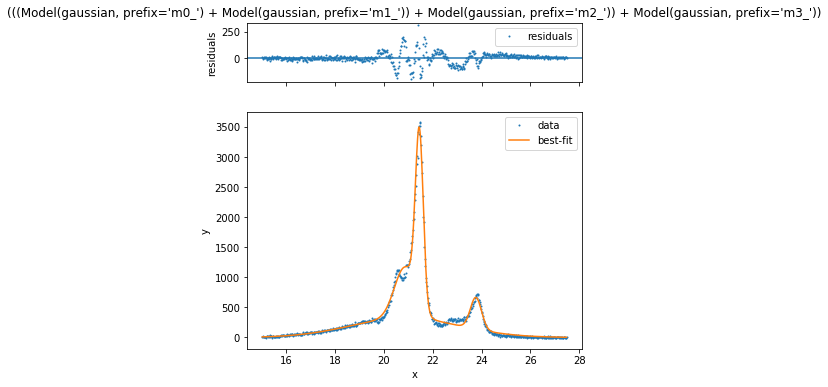

In [218]:
model, params = generate_model(spec)
output = model.fit(spec['y'], params, x=spec['x'])
fig, gridspec = output.plot(data_kws={'markersize':  1})
plot_to_blog(fig, 'xrd-fitting-xrd-total.png')

4


'images/xrd-fitting-xrd-components.png'

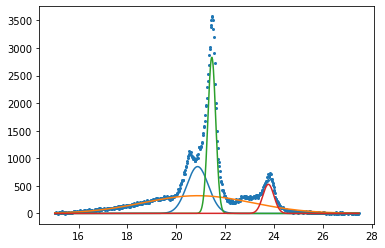

In [219]:
fig, ax = plt.subplots()
ax.scatter(spec['x'], spec['y'], s=4)
components = output.eval_components(x=spec['x'])
print(len(spec['model']))
for i, model in enumerate(spec['model']):
    if i == 4:
        continue
    else:
        ax.plot(spec['x'], components[f'm{i}_'],)

plot_to_blog(fig, 'xrd-fitting-xrd-components.png')

<IMG align="left" src="cores_ordem.png" alt="cores">

In [220]:
print_best_values(spec,output)

center   model            amplitude     sigma     gamma
[20.871] GaussianModel   :  930.338,    0.437
[20.876] GaussianModel   : 1795.415,    2.227
[21.453] GaussianModel   : 1138.096,    0.160
[23.769] GaussianModel   :  302.316,    0.229


In [221]:
crystallinity(output, [1])

0.5690485127578173

In [223]:
output